In [ ]:
import lamindb as ln
import lnschema_bionty as lb

import pandas as pd

from lightning.pytorch import Trainer, seed_everything
seed_everything(42, workers=True)

from scprint import scPrint
from scprint.utils import getBiomartTable

from scdataloader import Dataset
from scdataloader import DataModule
from scprint.dataloader import embed
from scdataloader.utils import load_genes
from scprint.dataloader import Collator

import torch 
torch.set_float32_matmul_precision('medium')

lb.settings.organism = "human"

%load_ext autoreload
%autoreload 2

INFO: Seed set to 42
2024-01-27 13:06:34,723:INFO - Seed set to 42


In [ ]:
## Gene embeddings
# embeddings = embed(genedf=genedf,
#     organism="homo_sapiens",
#     cache=True,
#     fasta_path="/tmp/data/fasta/",
#     embedding_size=1024,)
# embeddings.to_parquet('../data/temp/embeddings.parquet')
embeddings = pd.read_parquet('../data/temp/embeddings.parquet')
embeddings.columns = ['emb_'+str(i) for i in embeddings.columns]
# and annotations
biomart = getBiomartTable(attributes=['start_position', 'chromosome_name']).set_index('ensembl_gene_id')
biomart = biomart.loc[~biomart.index.duplicated(keep='first')]
biomart = biomart.sort_values(by=['chromosome_name', 'start_position'])
# and location
c = []
i = 0
prev_position = -100000
prev_chromosome = None
for _, r in biomart.iterrows():
    if r['chromosome_name'] != prev_chromosome or r['start_position'] - prev_position > 10_000:
        i += 1
    c.append(i)
    prev_position = r['start_position']
    prev_chromosome = r['chromosome_name']
print(f'reduced the size to {len(set(c))/len(biomart)}')
biomart['pos'] = c

downloading gene names from biomart
['ensembl_gene_id', 'hgnc_symbol', 'gene_biotype', 'entrezgene_id', 'start_position', 'chromosome_name']
reduced the size to 0.6722574020195106


In [ ]:
d_model = 256
m = torch.nn.AdaptiveAvgPool1d(d_model)
sembeddings = pd.DataFrame(
    data=m(torch.tensor(embeddings.values)), index=embeddings.index, columns=[f'emb_{i}' for i in range(d_model)]
)

In [ ]:
labels = {k: len(v) for k, v in mdataset.class_topred.items()}

cls_hierarchies = {}
for k, dic in mdataset.class_groupings.items():
    rdic = {}
    for sk, v in dic.items():
        rdic[mdataset.encoder[k][sk]] = [mdataset.encoder[k][i] for i in list(v)]
    cls_hierarchies[k] = rdic

df = sembeddings.join(biomart,how="inner")

genedf = load_genes(['NCBITaxon:9606'])
df = df.loc[genedf[genedf.index.isin(df.index)].index]

## look at test embedding and debug the embedding functions

In [ ]:
## put them in the dataloader class (but push and work on another branch for now)

## TODO: put this loading method on the explainer class

In [ ]:
import scanpy as sc
import anndata as ad

In [ ]:
obs = df.iloc[:,d_model:]
obs.index.name=None
adata = ad.AnnData(sembeddings, obs=obs)

,hgnc_symbol,gene_biotype,entrezgene_id,start_position,chromosome_name,pos
ENSG00000000003,TSPAN6,protein_coding,7105.0,100627108,X,45996
ENSG00000000005,TNMD,protein_coding,64102.0,100584936,X,45995
ENSG00000000419,DPM1,protein_coding,8813.0,50934867,20,24049
ENSG00000000457,SCYL3,protein_coding,57147.0,169849631,1,2679
ENSG00000000460,C1orf112,protein_coding,55732.0,169662007,1,2674
...,...,...,...,...,...,...
ENSG00000292359,ENSG00000292359,lncRNA,NaN,1661795,Y,46769
ENSG00000292363,CRLF2,protein_coding,64109.0,1190490,Y,46760
ENSG00000292366,VAMP7,protein_coding,6845.0,57067865,Y,47133
ENSG00000292372,WASH6P,protein_coding,NaN,57207346,Y,47136


In [ ]:
resolutions=[0.5, 1, 2]

In [ ]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

[
    sc.tl.leiden(adata, resolution=res, key_added="leiden_res" + str(res))
    for res in resolutions
]
sc.pl.umap(adata, color=["leiden_res" + str(res) for res in resolutions])

NameError: name 'resolutions' is not defined

In [ ]:
[
    sc.tl.leiden(adata, resolution=res, key_added="leiden_res" + str(res))
    for res in resolutions
]

[None, None, None]

# it was mostly already assessed previously in the test_embedding.ipynb notebook

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


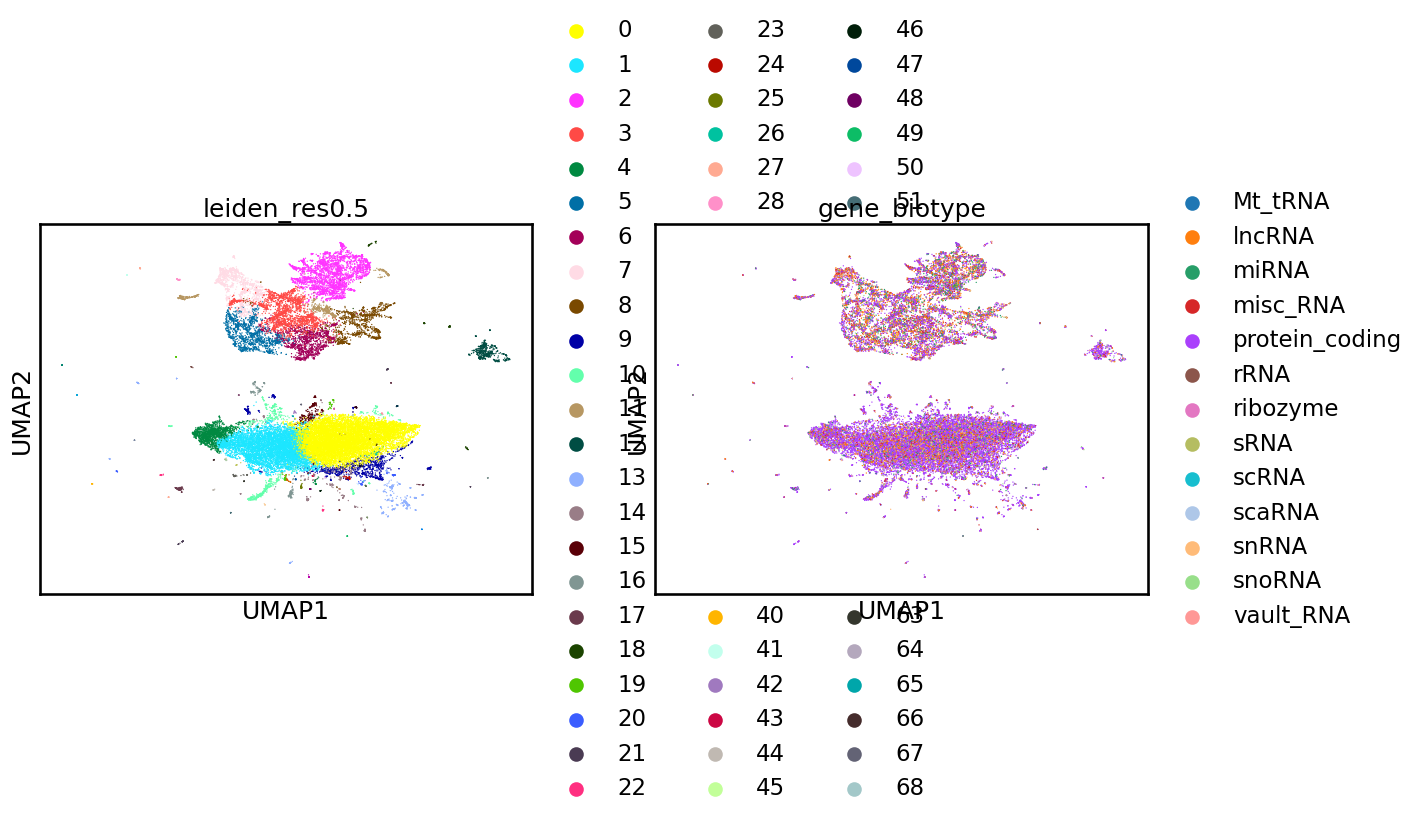

In [ ]:
sc.pl.umap(adata, color=["leiden_res0.5", "gene_biotype"])